# Line Tracing #

## Idea ##

Function: Main
1) Load 1 pixel Image
2) Give every pixel a id
3) Select a Starting Point
Function: Trace Line
1) Check all Pixels surrounding the Starting Point

In [23]:
import utils
import classes
import matplotlib.pyplot as plt
import networkx as nx

In [24]:
imageArray = utils.load1BitBWImage("./../src/testImages/","0.png")
colorImage = utils.loadRGBImage("./../src/testImages/","0.png")

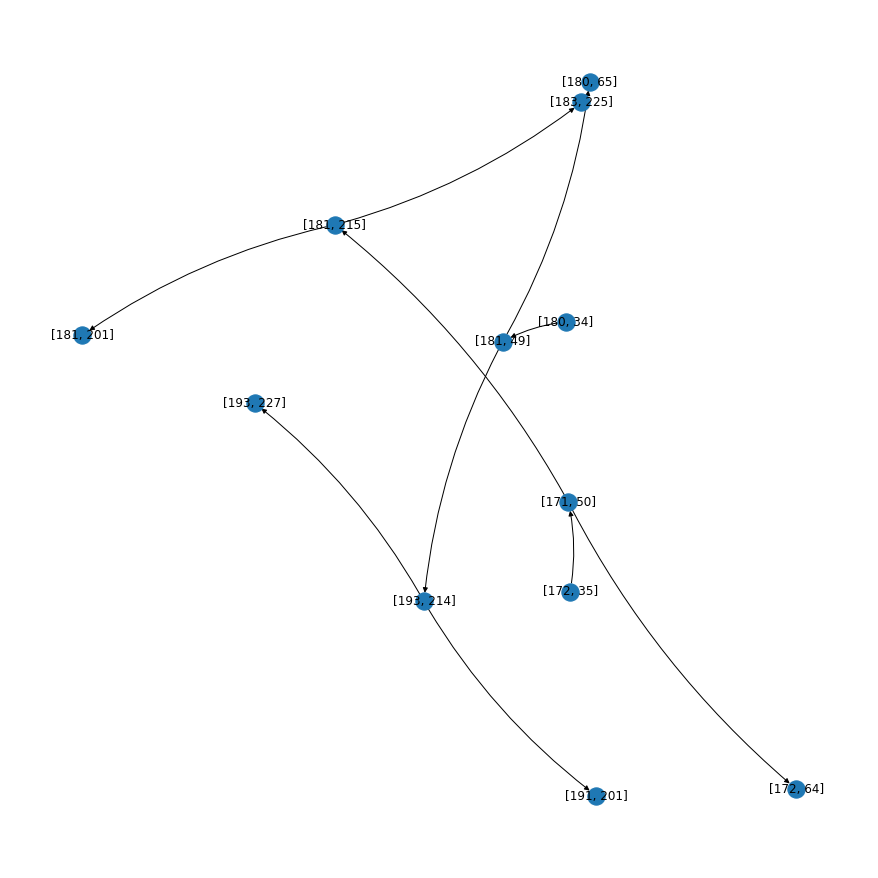

In [25]:
imageArray = utils.load1BitBWImage("./../src/testImages/","0.png")

class NodeType():
    pass
class EndNode(NodeType):
    pass
class IntersectionNode(NodeType):
    pass 
class CornerNode(NodeType):
    pass


def getAdjacentPixel(image,currentPixel,blackList):
    #AdjacentPixel Array       
    adjacentPixels = [[-1,-1],[0,-1],[1,-1], \
                        [-1,0],        [1,0], \
                        [-1,1], [0,1], [1,1]]
    validPixels = []
    for adj in adjacentPixels:
        adjacentPixel = [currentPixel[0]+adj[0],currentPixel[1]+adj[1]]
        if image[adjacentPixel[1]][adjacentPixel[0]] == 1:
            if not adjacentPixel in blackList:
                validPixels.append(adjacentPixel)
    return validPixels

# gets first black pixel in image
def findStaringPoint(image):
    for y in range(0,len(image)):
        for x in range(0,len(image)):
            if image[y][x] == 1:
                return [x,y]

## Runs along line until it finds the first Intersection or the first Endpoint
def findValidPoint(image,startPoint):
    def recursiveFindValidPoint(currentPixel,lastPixel):
        adjacentPixels = getAdjacentPixel(image,currentPixel,[])
        if len(adjacentPixels) > 2:
            return currentPixel
        if len(adjacentPixels) == 1:
            return currentPixel
        adjacentPixels = getAdjacentPixel(image,currentPixel,[lastPixel]) 
        return recursiveFindValidPoint(adjacentPixels[0],currentPixel)
    return recursiveFindValidPoint(startPoint,None)

def generateGraph(image,startPoint):
    visitedPixels = []
    graph = nx.MultiDiGraph()
    graph.add_node(str(startPoint))

    def recursiveGenerateGraph(currentPixel,lastPixel,lastGraphNode):

        #End Recursion if loop ends
        if currentPixel in visitedPixels:
            if str(currentPixel) in graph:
                graph.add_edge(lastGraphNode,str(currentPixel))
            return

        visitedPixels.append(currentPixel)
        adjacentPixels = getAdjacentPixel(image,currentPixel,[lastPixel])
        if len(adjacentPixels) == 0:
            #ENDPOINT
            if(str(currentPixel) != lastGraphNode):
                graph.add_node(str(currentPixel),nodeType=EndNode())
                graph.add_edge(lastGraphNode,str(currentPixel))
        elif len(adjacentPixels) == 1:
            #LINE
            recursiveGenerateGraph(adjacentPixels[0],currentPixel,lastGraphNode)
        else:
            #INTERSECTION
            if(str(currentPixel) != lastGraphNode):
                graph.add_node(str(currentPixel),nodeType=IntersectionNode())
                graph.add_edge(lastGraphNode,str(currentPixel))
            for adjacentPixel in adjacentPixels:
                recursiveGenerateGraph(adjacentPixel,currentPixel,str(currentPixel))

    recursiveGenerateGraph(startPoint,None,str(startPoint))
    return graph,visitedPixels

while True:
    startingPoint = findStaringPoint(imageArray)
    startingPoint = findValidPoint(imageArray,startingPoint)
    G,visitedPixels = generateGraph(imageArray,startingPoint)
    #Draw Graph
    subax1 = plt.figure(121,figsize=(12,12))
    nx.draw(G, with_labels=True,connectionstyle='arc3, rad = 0.1')  

    #Remove all visited Pixels
    for visitedPixel in visitedPixels:
        imageArray[visitedPixel[1]][visitedPixel[0]] = 0
        
    #Check if image is only white
    sum = 0
    def addSum(pixel):global sum; sum += pixel
    utils.foreachPixel(imageArray,addSum)
    if sum == 0:
        break
